In [194]:
"""
Pandas library for manipulating data
"""

import pandas as pd

"""
# numpy for numeric operations and specialized arrays
"""
import numpy as np


"""

"""
import statannotations

"""
seaborn for visualizing
"""

import seaborn as sns

# plotting library for figures
import matplotlib.pyplot as plt

# stats for anova
import scipy.stats as stats

import statsmodels.api as sm

from statsmodels.formula.api import ols


# pathlib for file management and filesystem navigation
from pathlib import Path

"""
sklearn is a standard ML toolkit
principal component analysis reduces the dimensions of the data linearly
down to only the principal components that explain most of the variation
"""
from sklearn.decomposition import PCA

from tqdm import tqdm

"""
Library to find the Shannon entropy, the measure of uncertainty or variability in a probability distribution
for distribution with probabilities pk, use the formula H = -sigma(pk * log(pk))
for relative entropy between two distributions pk and qk, use D = sigma(pk * log(pk/qk))
This is the summation of the product of each probabilitiy (pk) and its logarithm, then multiplying the result by -1

"""
from scipy.stats import entropy

"""
Silhouette score
"""
from sklearn.metrics import silhouette_score

"""
Since our gap gave an optimal k of 7, and the silhouette gave an optimal
k of 2, there may be a hierarchical structure to our data.

These two libraries will help elucidate the hierachy embedded in our data.
"""

from sklearn.mixture import GaussianMixture
import hdbscan

"""
t-distributed stochastic neighbor embedding is nonlinear dimensionality reduction for
visualization
preserves local neighborhoods, so rather than preserving absolute distances,
it preserves the probabilities of two points being neighbors in the original
dimensional space
"""
from sklearn.manifold import TSNE

""" KMeans is a clustering algorithm that assigns each point to one of k centroids by minimizing
squared euclidean distance within the clusters """
from sklearn.cluster import KMeans



In [ ]:

results_dir = Path("Results")
results_dir.mkdir(exist_ok=True)

#  for silhouettes
silhouette_summary = {}

# set global k value for number of clusters
k_val = 2

df = pd.read_csv("OlsenData_TableS6.csv")
print(df.head(2))

# definning the columns to use
time_columns = ['"0" EGF', '"1" EGF', '"5" EGF', '"10" EGF', '"20" EGF']


   Peptide ID    Accession                        Phosphopeptide sequence  \
0       53419  IPI00005792  APPGAPGPGPGSGAPGSQEEEEEPGLVEGDPGDGAIEDPELEAIK   
1       54096  IPI00006620                            TRTSIDSIDSGVELTTSPK   

  Fraction  pSTY  START AA  STOP AA  "0" EGF  "1" EGF  "5" EGF  "10" EGF  \
0  nuclear     1        79      123     0.37     0.33      1.0      0.69   
1  nuclear     3       231      249     0.21     0.33      1.0      0.18   

   "20" EGF Cluster ID  membership.A  membership.B  membership.C  \
0      0.67          A          0.44          0.19          0.15   
1      0.18          A          0.66          0.07          0.05   

   membership.D  membership.E  membership.F  
0          0.10          0.05          0.07  
1          0.04          0.09          0.09  


In [196]:

"""
For clustering and distance metrics, missing values would invalidate our calculations,
so we convert our values to numeric, coerce any possible errors to NaN, drop those NaN values
from the dataframe and finally, ensure that our data is of type float32 fo the kmeans
"""

X = (
    df[time_columns]
    .apply(pd.to_numeric, errors="coerce")
    .dropna()
    .to_numpy(dtype=np.float32)
)

"""
X[0] - [0.37 0.33 1.  0.69 0.67]
"""

'\nX[0] - [0.37 0.33 1.  0.69 0.67]\n'

In [197]:

"""
calculate z score for each peptide, row wise. 
Rows are designated by the axis=1, dimensions are retained with argument keepdims=True
Each peptide's mean is subtracted, and the result is divided by its standard deviation

Using Z score normalized the magnitude differences between peptides so clustering emphasizes
shape of peptide time course instead of the absolute intensity.
Using Z score sets each peptide to a mean of 0 and std of 1 across its 5 time points.

Here we take advantage of numpy's boardcasting feature to perform operations on the df

"""

Xz = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True))




In [198]:

"""
Here, principal component analysis is performed to find orthogonal directions that capture
the largest variance. Projecting into the first two components gives a 2D summary of the main
dynamic patterns

n_components argument defines how many components we are computing
random_state is used for reproducibility
"""


pca = PCA(n_components=5, random_state=42)

# fit our pca model with the z scores of our data, Xz
Z = pca.fit_transform(Xz)



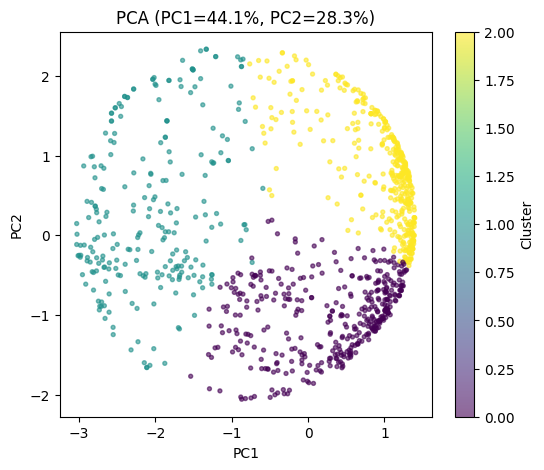

In [199]:

"""
k means clustering.. Partitions data int ok clusters by minimizing the 
within cluster squared euclidean distance to centroids

n_clusters sets the number of clusters for our kmeans

n_init allows us to use 10 different centroid seeds and pick the best

random_state ensures reproducible labels
"""

kmeans = KMeans(n_clusters=k_val, n_init=10, random_state=42)
# compute cluster centers and predict cluster index for each z score in Z
labels = kmeans.fit_predict(Z)

plt.figure(figsize=(6, 5))
plt.scatter(Z[:, 0], Z[:, 1], c=labels, s=8, alpha=0.6, cmap='viridis')
plt.colorbar(label='Cluster')
plt.title(
    f"PCA (PC1={pca.explained_variance_ratio_[0]*100:.1f}%, "
    f"PC2={pca.explained_variance_ratio_[1]*100:.1f}%)"
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.savefig(results_dir / f"pca_variance_k_{k_val}.png", dpi=300)

plt.show()



In [226]:
for i in range(0,len(pca.explained_variance_ratio_)):
    print(f"{(pca.explained_variance_ratio_[i])*100:.8f}")


44.05484009
28.29099655
16.49395561
11.16020107
0.00000296


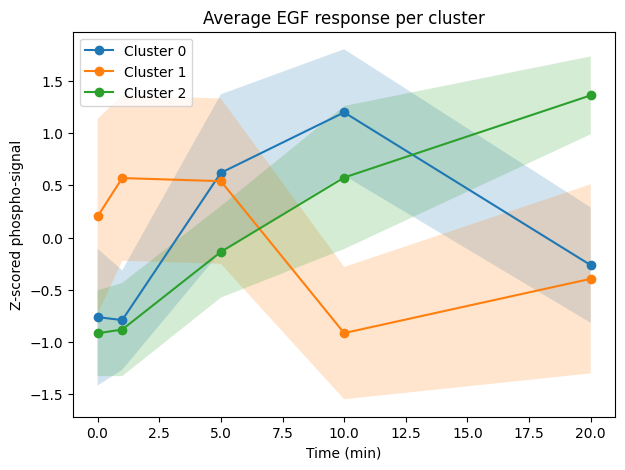

In [201]:
"""
X_df includes each column as a time point
"""
minutes = [0, 1, 5, 10, 20]
# new dataframe x_df that contains the z scores and the corresponding time points
# the time points are in the object minutes
X_df = pd.DataFrame(Xz, columns=minutes)
# a new column is made to assign each row to a cluster
# clusters are in the labels object
X_df["cluster"] = labels
plt.figure(figsize=(7, 5))
for c in sorted(X_df["cluster"].unique()):
    # mu is the average of the
    mu = X_df[X_df.cluster == c].iloc[:, :-1].mean()
    sd = X_df[X_df.cluster == c].iloc[:, :-1].std()
    plt.plot(minutes, mu, marker="o", label=f"Cluster {c}")
    plt.fill_between(minutes, mu - sd, mu + sd, alpha=0.2)
plt.xlabel("Time (min)")
plt.ylabel("Z-scored phospho-signal")
plt.title("Average EGF response per cluster")
plt.legend()
plt.savefig(results_dir / f"mean_timecourses_k_{k_val}.png", dpi=300)
plt.show()
plt.close()

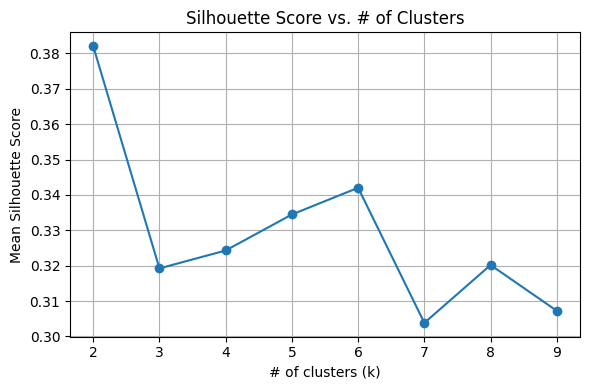

In [202]:
################### Silhouette Scores ##################

"""
A silhouette score is a metricu in unsupervised learning to evaluate the quality of clusters 
created by a clustering algorithm. 
It measures how well each data point fits into its assigned cluster by
comparing its average intra cluster distance to its average near cluster distance. 
The scores range from -1 to +1, where a higher score indicates better defined clusters, 
a score near 0 suggests overlapping 
clusters, and a negative score omplies a point may be in the wrong cluster

Validation via silhouette and gap for kmeans
"""

# initialize list
silhouette_scores = []

# define k range for cluster testing
K_range = range(2, 10)

# compute score and add to list
for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(Z)
    sil = silhouette_score(Z, labels)
    silhouette_scores.append(sil)

plt.figure(figsize=(6, 4))
plt.plot(K_range, silhouette_scores, marker="o")
plt.title("Silhouette Score vs. # of Clusters")
plt.xlabel("# of clusters (k)")
plt.ylabel("Mean Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.savefig(results_dir / f"silhouette_scores_k_{k_val}.png", dpi=300)
plt.show()
plt.close()

# print best k
best_kmeans_sillhouette = K_range[np.argmax(silhouette_scores)]
silhouette_summary["KMeans_best_k"] = best_kmeans_sillhouette
silhouette_summary["KMeans_silhouette"] = max(silhouette_scores)


computing gap stat: 100%|██████████| 9/9 [00:04<00:00,  1.92it/s]


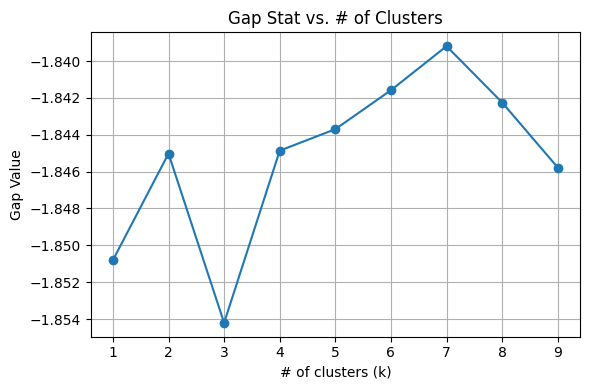

In [203]:

"""
Increasing number of clusters reduces the within cluster sum of squared distances, referred tp as
intertia. If inertia is used as a metric, the pitfall of increasing clusters
is inevitable. 

The gap statistic aims to fix this by measuring how much better the clustering is than
what would be expected from random noise.

If the data has real clusters, the inertia will be much lower than random data with no
structure. If adding more cluseters doesnt imrpove much, beyond what random noise would,
the k needs to be lowered.

A gap is the difference betwwen the expected log(Wk) from a reference dataset
and the observed log(Wk) from the actual dataset. 

Both Wk values represent within cluster disperson, applied to the actual and random
datasets, respectively

The optimal number of clusters, k is the smallest k such that the Gap(k) >= Gap(k + 1) - s(k+1)
where s(k+1) is the standard deviation of the simulated gap values that adjusts for simulation 
variability in the reference datasets

Here, we pick the k with the largest gap value since that represents a large difference
between our actual data and random noise.
"""


def gap_stat(data, refs=10, max_k=10):
    gaps = np.zeros(max_k - 1)
    for k in tqdm(range(1, max_k), desc="computing gap stat"):
        km = KMeans(n_clusters=k_val, n_init=10, random_state=42)
        km.fit(data)
        disp = np.log(km.inertia_)

        ref_disps = np.zeros(refs)
        for i in range(refs):
            random_ref = np.random.random_sample(size=data.shape)
            km_ref = KMeans(n_clusters=k_val, n_init=10, random_state=42)
            km_ref.fit(random_ref)
            ref_disps[i] = np.log(km_ref.inertia_)
        # computes the gaps for each k
        gaps[k - 1] = np.mean(ref_disps) - disp
    return gaps


gaps = gap_stat(Z, refs=10, max_k=10)
plt.figure(figsize=(6, 4))
plt.plot(range(1, 10), gaps, marker="o")
plt.title("Gap Stat vs. # of Clusters")
plt.xlabel("# of clusters (k)")
plt.ylabel("Gap Value")
plt.grid(True)
plt.tight_layout()
plt.savefig(results_dir / f"gap_stat_k_{k_val}.png", dpi=300)
plt.show()
plt.close()




In [204]:
best_k_gap = np.argmax(gaps) + 1
print(f"optimal k by gap: {best_k_gap}")

silhouette_summary["Gap_best_k"] = best_k_gap
silhouette_summary["Gap_values"] = gaps.tolist()

optimal k by gap: 7


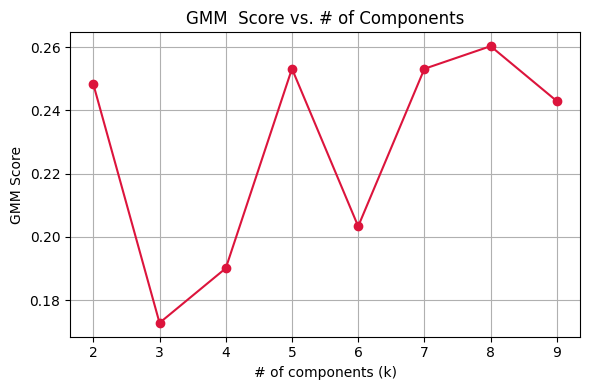

In [205]:


############## DB SCAN & GMM ###############
"""
GMM Gaussian Mixture MOdel reveals soft clusters (overlapping subgroups).
Each point has a membership probability to all clusters, similar to fuzzy 

"""

gmm_silhouette_scores = []
for k in K_range:
    gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=42)
    gmm_labels = gmm.fit_predict(Z)
    sil = silhouette_score(Z, gmm_labels)
    gmm_silhouette_scores.append(sil)

plt.figure(figsize=(6, 4))
plt.plot(K_range, gmm_silhouette_scores, marker="o", color="crimson")
plt.title("GMM  Score vs. # of Components")
plt.xlabel("# of components (k)")
plt.ylabel("GMM Score")
plt.grid(True)
plt.tight_layout()
plt.savefig(results_dir / f"gmm_scores_k_{k_val}.png", dpi=300)
plt.show()
plt.close()



In [206]:
best_k_gmm = K_range[np.argmax(gmm_silhouette_scores)]
silhouette_summary["GMM_best_k"] = best_k_gmm
silhouette_summary["GMM_silhouette"] = max(gmm_silhouette_scores)

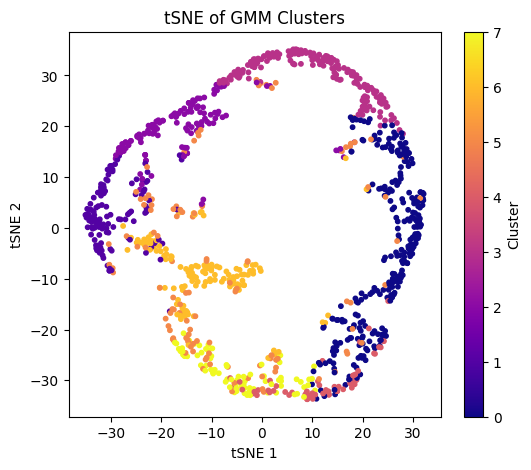

In [207]:
# visualize GMM clustering on tSNE space
gmm_best = GaussianMixture(
    n_components=best_k_gmm, covariance_type="full", random_state=42
)
gmm_labels = gmm_best.fit_predict(Z)

plt.figure(figsize=(6, 5))
plt.scatter(U[:, 0], U[:, 1], c=gmm_labels, cmap="plasma", s=10)
plt.title("tSNE of GMM Clusters")
plt.xlabel("tSNE 1")
plt.ylabel("tSNE 2")
plt.colorbar(label="Cluster")
plt.savefig(results_dir / f"tsne_gmm_clusters_k_{k_val}.png", dpi=300)
plt.show()
plt.close()

/Users/hypoglossal/Documents/Research/SynBio/MAPD/environments/olsen/lib/python3.14/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hypoglossal/Documents/Research/SynBio/MAPD/environments/olsen/lib/python3.14/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


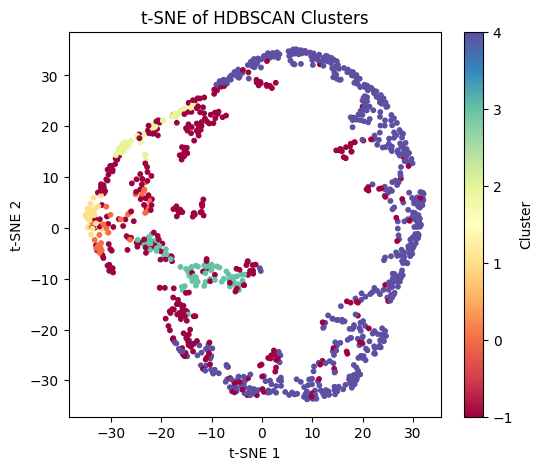

In [208]:

"""
HDBSCAN revals hard clusters and outliers.

"""

# min_cluster_size defines the smallest size of dense regions
hdb = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=5, cluster_selection_epsilon=0.0)
hdb_labels = hdb.fit_predict(Z)

# compute silhouette only if multiple clusters exist
if len(set(hdb_labels)) > 1:
    hdb_sil = silhouette_score(Z, hdb_labels)
    silhouette_summary["HDBSCAN_silhouette"] = hdb_sil
else:
    silhouette_summary["HDBSCAN_silhouette"] = None

plt.figure(figsize=(6, 5))
plt.scatter(U[:, 0], U[:, 1], c=hdb_labels, cmap="Spectral", s=10)
plt.title("t-SNE of HDBSCAN Clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label="Cluster")
plt.savefig(results_dir / f"tsne_hdbscan_clusters_k_{k_val}.png", dpi=300)
plt.show()
plt.close()


In [209]:

print("\n\n==== Validation Scores Summary  ====")
for method, score in silhouette_summary.items():
    print(f"{method:20s}: {score}")


print("\n\n")




==== Validation Scores Summary  ====
KMeans_best_k       : 2
KMeans_silhouette   : 0.38206982612609863
Gap_best_k          : 7
Gap_values          : [-1.8508067498023104, -1.845020537920293, -1.8542088954306672, -1.8448625560932985, -1.8436955106335153, -1.8415824240564822, -1.8391906429877452, -1.8422494398561087, -1.8457767226707196]
GMM_best_k          : 8
GMM_silhouette      : 0.26028889417648315
HDBSCAN_silhouette  : 0.1678573191165924





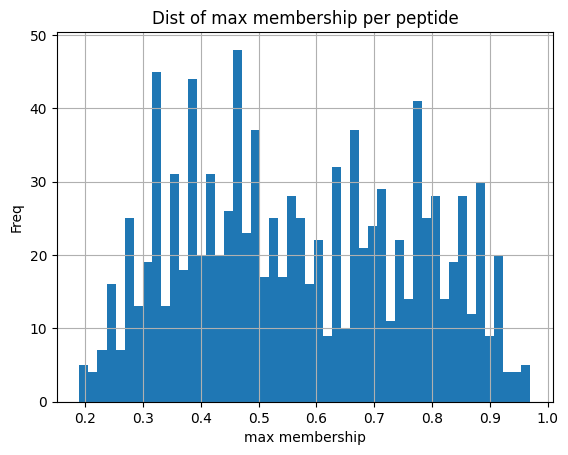

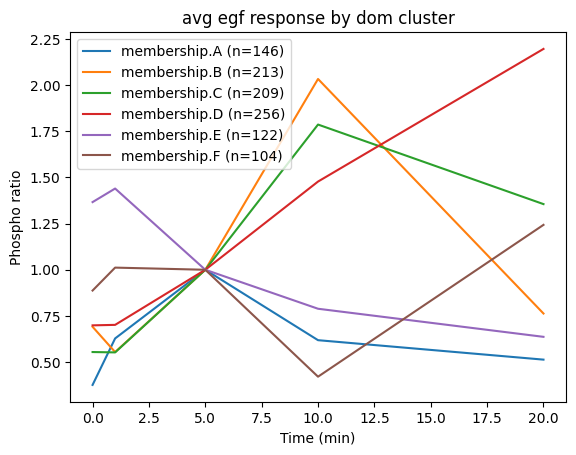

In [210]:

"""

Exploring memberships as experimental variables
"""

memberships = df.filter(like="membership").apply(pd.to_numeric, errors="coerce")
memberships.sum(axis=1).describe()
memberships.max(axis=1).hist(bins=50)
plt.title("Dist of max membership per peptide")
plt.xlabel("max membership")
plt.ylabel("Freq")
plt.show()

df["dominant_cluster"] = memberships.idxmax(axis=1)
df["dominant_strength"] = memberships.max(axis=1)


for c in memberships.columns:
    mask = df["dominant_cluster"] == c
    mu = df.loc[mask, time_columns].mean()
    plt.plot([0, 1, 5, 10, 20], mu, label=f"{c} (n={mask.sum()})")
plt.legend()
plt.title("avg egf response by dom cluster")
plt.xlabel("Time (min)")
plt.ylabel("Phospho ratio")
plt.show()


In [211]:

"""
'fuzziness index' = entropy per peptide


Shannon entropy measures the uncertainty or variability in a probability distribution. So we are taking
the membership values, which represent probabilities of peptides belonging to a certain cluster
and measuring the variance of the membership of each peptide to a group/cluster for all of the peptides

Entropy values closer to 0 suggest that the peptide has dominant membership to one particular cluster
This may represent a phosphite responding on one distinct pattern

Entropy values closer to 1 suggest that the phosphotsite is shared between clusters
"""


df["entropy"] = memberships.apply(
    lambda x: entropy(x, base=len(memberships.columns)), axis=1
)


entropy_by_protein = df.groupby("Accession")["entropy"].mean()
print("Entropy by protein \n")
print(entropy_by_protein.head(15))


Entropy by protein 

Accession
IPI00000155    0.217481
IPI00000162    0.795655
IPI00000846    0.931677
IPI00000858    0.578887
IPI00000875    0.366862
IPI00001466    0.749668
IPI00001632    0.633405
IPI00001727    0.904510
IPI00002255    0.827530
IPI00002335    0.578318
IPI00002386    0.410938
IPI00002483    0.953680
IPI00002569    0.552074
IPI00002591    0.283196
IPI00002804    0.978960
Name: entropy, dtype: float64


In [212]:

"""
Next: mapping to known pathways
taking the dominant cluster or top 2 memberships per peptide
map them to proteins using uniprot or phosphositeplus
do enrichment analysis, reactome or STRING, per cluster

this should show which clusters correspond to Early EGFR autophosphorylation events, mapk/erk cascades,
cytosekeltal remodeling, nuclear transcriptional feedback

then I need to visualize it somehow.. maybe a membership heatmap, peptides vs clusters, colored by strength
entropy histogram, network overlay where i can map cluster memberships onto a string protein interaction
graph
"""


'\nNext: mapping to known pathways\ntaking the dominant cluster or top 2 memberships per peptide\nmap them to proteins using uniprot or phosphositeplus\ndo enrichment analysis, reactome or STRING, per cluster\n\nthis should show which clusters correspond to Early EGFR autophosphorylation events, mapk/erk cascades,\ncytosekeltal remodeling, nuclear transcriptional feedback\n\nthen I need to visualize it somehow.. maybe a membership heatmap, peptides vs clusters, colored by strength\nentropy histogram, network overlay where i can map cluster memberships onto a string protein interaction\ngraph\n'

In [213]:

"""
Here I find the top membership just to get an idea of how my uniprot query should be structured. 
Then I need to create a dictionary containing ID:sequence pairs linked to the
entropy? The entropy is a measure of how strongly a peptide belongs to a specific cluster, 
biologicall signifying possibly important signaling pathway proteins? So I want
to create a new dataframe with the ID, Sequence, entropy, membership value, and uniprot ID, 
where uniprot ID will, I guess, be the ID of the protein on uniprot
that most strongly matches our sequence.

revised: Here I identify peptides with high membership to examine which sites are most confidently 
assigned to a single kinetic pattern.
These high membership peptides are likely to be well-defined signaling nodes, 
and their sequences will be used to guide UniProt queries. 
"""
high_membership_threshold = 0.75

high_conf_peptides = df[df["dominant_strength"] >= high_membership_threshold].copy()

peptide_dict = (
    high_conf_peptides[
        ["Accession", "Phosphopeptide sequence", "entropy", "dominant_strength"]
    ]
    .set_index("Accession")
    .T.to_dict()
)



/var/folders/2b/g2gths1d7m3b6d4srzqc5zxm0000gn/T/ipykernel_9310/1826851108.py:24: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  .T.to_dict()


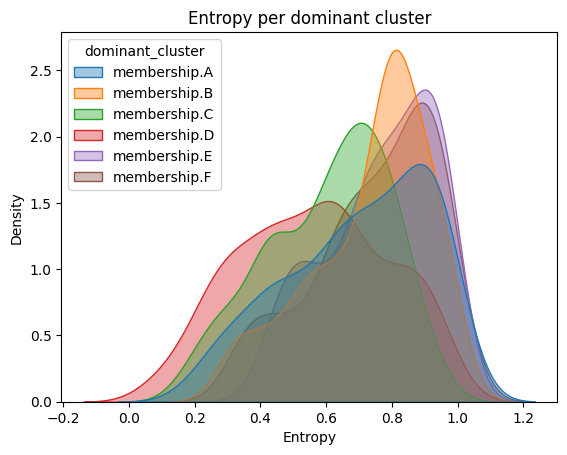

In [214]:

"""
Visualizing per cluster to see if some cluster have lower entropy than others
"""
sns.kdeplot(
    data=df,
    x="entropy",
    hue="dominant_cluster",
    common_norm=False,
    fill=True,
    alpha=0.4,
)
plt.title("Entropy per dominant cluster")
plt.xlabel("Entropy")
plt.ylabel("Density")
plt.savefig(results_dir / f"Entropy_Per_Dom_Cluster.png", dpi=300)
plt.show()


In [215]:

"""
one way ANOVA entropy ~ dominant cluster

Type 2 anova tests each main effect in the presence of other main effect without considering
interactions. Used for when there is no significanti nteraction in unbalanced data.
"""

anova_model = ols("entropy ~ C(dominant_cluster)", data=df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print("\n")
print(anova_table)

"""
Anova Table
                       sum_sq      df          F        PR(>F)
C(dominant_cluster)   6.821040     5.0  35.286787  2.009496e-33
Residual             40.361657  1044.0        NaN           NaN


The p value is below 0.05 so we can reject the null hypothesis that each cluster entropy mean 
do not differ significantly. The difference in means being negligible indicates that most of the
peptides are similar in function

"""





                        sum_sq      df          F        PR(>F)
C(dominant_cluster)   6.821040     5.0  35.286787  2.009496e-33
Residual             40.361657  1044.0        NaN           NaN


'\nAnova Table\n                       sum_sq      df          F        PR(>F)\nC(dominant_cluster)   6.821040     5.0  35.286787  2.009496e-33\nResidual             40.361657  1044.0        NaN           NaN\n\n\nThe p value is below 0.05 so we can reject the null hypothesis that each cluster entropy mean \ndo not differ significantly. The difference in means being negligible indicates that most of the\npeptides are similar in function\n\n'

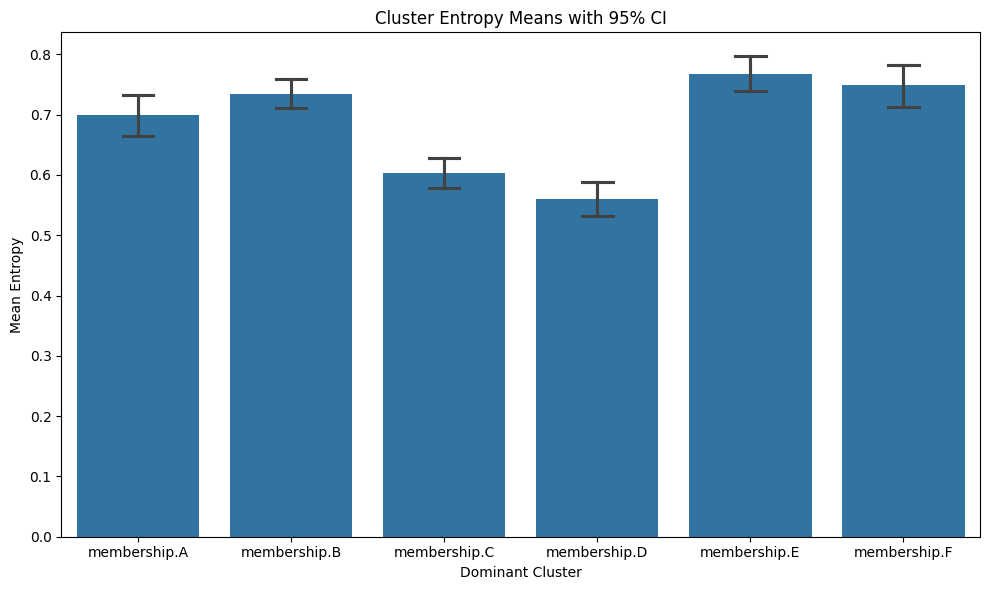

In [216]:
plt.figure(figsize=(10,6))
sns.barplot(
    x="dominant_cluster",
    y="entropy",
    data=df,
    errorbar=('ci', 95),
    capsize=0.2
)

plt.title("Cluster Entropy Means with 95% CI")
plt.xlabel("Dominant Cluster")
plt.ylabel("Mean Entropy")

plt.tight_layout()
plt.savefig("Results/entropy_ci_barplot.png", dpi=300)
plt.show()
plt.close()

In [217]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd
import matplotlib.pyplot as plt

df["dominant_cluster"] = df["dominant_cluster"].astype(str)


tukey = pairwise_tukeyhsd(
    endog=df["entropy"],
    groups=df["dominant_cluster"],
    alpha=0.05
)

print("\nTukey HSD Results")
print(tukey)


tukey_df = pd.DataFrame(
    data=tukey._results_table.data[1:],     
    columns=tukey._results_table.data[0]    
)


tukey_df.to_csv("Results/tukey_entropy_results.csv", index=False)
print("\nSaved Tukey results to Results/tukey_entropy_results.csv")

diffs = tukey_df["meandiff"].astype(float)
lower_ci = tukey_df["lower"].astype(float)
upper_ci = tukey_df["upper"].astype(float)
pairs = tukey_df[["group1", "group2"]].astype(str).apply("-".join, axis=1)

plt.figure(figsize=(12,6))
plt.errorbar(
    x=range(len(diffs)),
    y=diffs,
    yerr=[diffs - lower_ci, upper_ci - diffs],
    fmt='o',
    capsize=5,
    linewidth=1.5
)

plt.axhline(0, linestyle='--', color='gray')
plt.title("Tukey HSD Entropy Differences Between Clusters")
plt.xticks(range(len(diffs)), pairs, rotation=45)
plt.xlabel("Cluster Pair")
plt.ylabel("Mean Entropy Difference")

plt.tight_layout()
plt.savefig("Results/tukey_entropy_plot.png", dpi=300)
plt.close()

print("Saved Tukey significance plot as tukey_entropy_plot.png ")




Tukey HSD Results
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
membership.A membership.B    0.036 0.5292 -0.0243  0.0963  False
membership.A membership.C  -0.0953 0.0001 -0.1559 -0.0348   True
membership.A membership.D  -0.1384    0.0 -0.1966 -0.0802   True
membership.A membership.E   0.0688 0.0501    -0.0  0.1377  False
membership.A membership.F   0.0506  0.339 -0.0214  0.1227  False
membership.B membership.C  -0.1313    0.0  -0.186 -0.0767   True
membership.B membership.D  -0.1744    0.0 -0.2265 -0.1223   True
membership.B membership.E   0.0328 0.6833 -0.0309  0.0966  False
membership.B membership.F   0.0146 0.9894 -0.0525  0.0818  False
membership.C membership.D  -0.0431 0.1754 -0.0954  0.0093  False
membership.C membership.E   0.1642    0.0  0.1002  0.2281   True
membership.C membership.F    0.146    0.0  0.0786  0.2133   True
member